In [1]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

2023-11-17 13:54:49.455336: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 13:54:49.482382: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 13:54:49.959638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [2]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [3]:
class_ids = [
    "car",
    "pedestrian",
    "trafficLight-Red",
    "trafficLight-RedLeft",
    "trafficLight",
    "biker",
    "truck",
    "trafficLight-Green",
    "trafficLight-GreenLeft",
    "trafficLight-Yellow",
    "trafficLight-YellowLeft",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "./data/images"
path_annot = "./data/annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [4]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
        
    #print(classes)
    #print(class_mapping)
    
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/29800 [00:00<?, ?it/s]

In [5]:
class_mapping.values()

dict_values(['car', 'pedestrian', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight', 'biker', 'truck', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft'])

In [6]:
classes

[[6, 0, 0, 1],
 [6, 0, 0, 1],
 [6, 0, 6, 0],
 [6, 0, 6, 0],
 [1, 6, 0, 0, 0, 0],
 [1, 6, 0, 0, 0, 0],
 [1, 6, 0, 0, 0, 0],
 [1, 6, 0, 0, 0, 0],
 [1, 6, 0, 0, 0],
 [1, 6, 0, 0, 0],
 [1, 6, 0, 0, 0],
 [6, 1, 0, 6, 0],
 [6, 1, 0, 6, 0],
 [0, 0, 1, 0, 6, 0],
 [0, 0, 1, 0, 6, 0],
 [0, 0, 0, 0, 1, 0, 6, 0],
 [0, 0, 0, 0, 1, 0, 6, 0],
 [0, 0, 0, 0, 1, 0, 6, 0, 0],
 [0, 0, 0, 0, 1, 0, 6, 0, 0],
 [0, 0, 0, 0, 0, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 6, 0, 0, 0],
 [0, 0, 0, 0, 0, 6, 0, 0, 0],
 [0, 0, 1, 6, 0, 0],
 [0, 0, 1, 6, 0, 0],
 [0, 0, 0, 0, 6, 0, 0],
 [0, 0, 0, 0, 6, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0,

In [7]:
bbox

[[[219.0, 244.0, 227.0, 258.0],
  [230.0, 247.0, 242.0, 261.0],
  [254.0, 246.0, 269.0, 265.0],
  [467.0, 207.0, 486.0, 319.0]],
 [[219.0, 244.0, 227.0, 258.0],
  [230.0, 247.0, 242.0, 261.0],
  [254.0, 246.0, 269.0, 266.0],
  [467.0, 207.0, 486.0, 318.0]],
 [[199.0, 247.0, 208.0, 263.0],
  [207.0, 252.0, 218.0, 265.0],
  [388.0, 219.0, 446.0, 263.0],
  [233.0, 251.0, 248.0, 271.0]],
 [[199.0, 247.0, 208.0, 263.0],
  [207.0, 252.0, 218.0, 265.0],
  [388.0, 219.0, 446.0, 263.0],
  [234.0, 251.0, 248.0, 271.0]],
 [[127.0, 252.0, 130.0, 264.0],
  [184.0, 243.0, 195.0, 265.0],
  [192.0, 248.0, 205.0, 267.0],
  [221.0, 249.0, 236.0, 268.0],
  [412.0, 210.0, 449.0, 261.0],
  [440.0, 214.0, 494.0, 255.0]],
 [[126.0, 252.0, 129.0, 264.0],
  [184.0, 242.0, 195.0, 265.0],
  [192.0, 248.0, 205.0, 266.0],
  [221.0, 248.0, 236.0, 268.0],
  [412.0, 209.0, 449.0, 260.0],
  [440.0, 213.0, 494.0, 254.0]],
 [[117.0, 253.0, 120.0, 265.0],
  [178.0, 241.0, 190.0, 264.0],
  [184.0, 247.0, 196.0, 269.0],
  

In [8]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2023-11-17 13:54:54.808613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 13:54:54.811951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 13:54:54.812051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [10]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [11]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [12]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [16]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [17]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [18]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [19]:

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [21]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

5960/5960 [==============================] - 1117s 187ms/step - loss: 2.1523 - box_loss: 1.9726 - class_loss: 0.1798 - val_loss: 2.6149 - val_box_loss: 2.3827 - val_class_loss: 0.2322


1/1 [==============================] - 0s 195ms/step


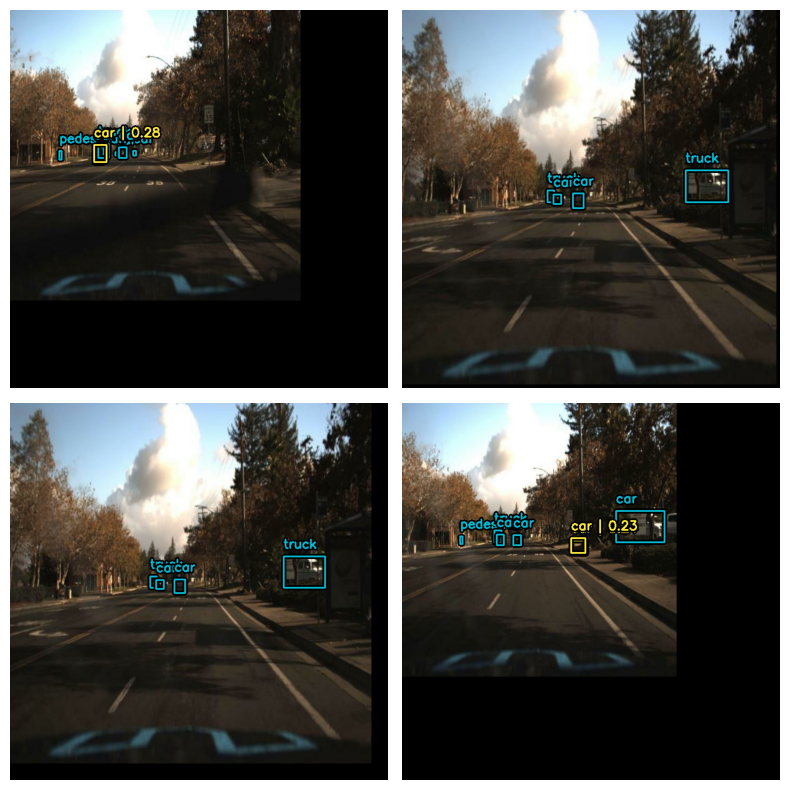

In [22]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")